In [6]:
%autosave 0
%matplotlib notebook

from __future__ import division, print_function
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import pyedflib

fig_w, fig_h = (4.5, 3.5)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.allow_growth = False
config.gpu_options.visible_device_list = '0'
set_session(tf.Session(config=config))

Autosave disabled


## Configuration settings

In [13]:
import mod_edf

path_folder = '/share/datasets/sleep-edfx/'

edf_ids_excluded =  ['SC4061', 'ST7071', 'ST7092', 'ST7132', 'ST7141']

channels_ref = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']

channels_ref_short = ['EEG1', 'EEG2', 'EOG1', 'EMG1']

metric_short = {'loss': 'loss', 'categorical_accuracy': 'acc'}

freq_target = 60

## Get dataset files

In [14]:
# get list of filenames
edf_files = [item for item in os.listdir(path_folder)
                  if (os.path.splitext(item)[1]).lower()=='.edf']

edf_first_night = [item for item in os.listdir(path_folder)
                  if (os.path.splitext(item)[1]).lower()=='.edf' and item[5]=='1' ]


edf_ids = set([item[:6] for item in edf_first_night
                        if item[:6]not in edf_ids_excluded])
psg_files, hyp_files = ([], [])

for edf_id in sorted(edf_ids):
    
    psg_files += [[os.path.join(path_folder, item) for item in edf_first_night
                     if (item[:6]==edf_id and item.endswith('-PSG.edf'))][0]]

    hyp_files += [[os.path.join(path_folder, item) for item in edf_first_night
                     if (item[:6]==edf_id and item.endswith('-Hypnogram.edf'))][0]]


## Get files informations

Get informations about files durations, start time for each file

In [15]:
for psg_file, hyp_file in zip(psg_files, hyp_files):
        
    with pyedflib.EdfReader(os.path.join(path_folder, psg_file)) as psg, \
         pyedflib.EdfReader(os.path.join(path_folder, hyp_file)) as hyp:
        psg_start_datetime = psg.getStartdatetime()
        hyp_start_datetime = hyp.getStartdatetime()
        
        psg_file_duration = psg.getFileDuration()
        hyp_file_duration = sum(hyp.readAnnotations()[1])
        
        print("psg_start_datetime:"+str(psg_start_datetime))
        print("Duration_psg:"+str(psg_file_duration))

psg_start_datetime:1989-04-24 16:13:00
Duration_psg:79500
psg_start_datetime:1989-03-29 16:49:00
Duration_psg:84060
psg_start_datetime:1989-04-05 16:48:00
Duration_psg:84120
psg_start_datetime:1989-04-10 16:50:00
Duration_psg:84600
psg_start_datetime:1989-04-24 16:50:00
Duration_psg:77100
psg_start_datetime:1989-04-26 16:25:00
Duration_psg:81660
psg_start_datetime:1989-05-17 17:05:00
Duration_psg:84300
psg_start_datetime:1989-05-24 16:37:00
Duration_psg:83880
psg_start_datetime:1989-06-05 16:24:00
Duration_psg:81960
psg_start_datetime:1989-04-17 16:50:00
Duration_psg:81600
psg_start_datetime:1989-05-01 16:29:00
Duration_psg:79260
psg_start_datetime:1989-05-22 16:02:00
Duration_psg:83580
psg_start_datetime:1989-06-14 16:19:00
Duration_psg:84420
psg_start_datetime:1989-06-19 16:05:00
Duration_psg:82680
psg_start_datetime:1989-06-21 16:40:00
Duration_psg:78600
psg_start_datetime:1989-07-10 16:31:00
Duration_psg:78780
psg_start_datetime:1989-07-12 16:09:00
Duration_psg:82260
psg_start_date

## Check time alignment



The start time and duration of PSG is compared to that of hypnogram, and differences are reported.

In [16]:
print('Time delta between PSG and hypnogram\n')

for psg_file, hyp_file in zip(psg_files, hyp_files):
        
    with pyedflib.EdfReader(os.path.join(path_folder, psg_file)) as psg, \
         pyedflib.EdfReader(os.path.join(path_folder, hyp_file)) as hyp:
        
        psg_start_datetime = psg.getStartdatetime()
        hyp_start_datetime = hyp.getStartdatetime()
        psg_file_duration = psg.getFileDuration()
        hyp_start, hyp_duration, hyp_score = hyp.readAnnotations()
        
        if hyp_score[-1][-1]=='?':
            hyp_start = hyp_start[:-1]
            hyp_duration = hyp_duration[:-1]
            hyp_score = hyp_score[:-1]
            
        hyp_file_duration = sum(hyp_duration)

        time_delta = int(psg_file_duration-hyp_file_duration)
        
        assert (psg_start_datetime - hyp_start_datetime).total_seconds()==0, \
               'ERROR: different starting time.'
        
        if time_delta==0:
            print('ok\t', psg_file, hyp_file)
        else:
            print(time_delta, 's\t', psg_file, hyp_file, hyp_score[-1])


Time delta between PSG and hypnogram

ok	 /share/datasets/sleep-edfx/SC4001E0-PSG.edf /share/datasets/sleep-edfx/SC4001EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4011E0-PSG.edf /share/datasets/sleep-edfx/SC4011EH-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4021E0-PSG.edf /share/datasets/sleep-edfx/SC4021EH-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4031E0-PSG.edf /share/datasets/sleep-edfx/SC4031EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4041E0-PSG.edf /share/datasets/sleep-edfx/SC4041EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4051E0-PSG.edf /share/datasets/sleep-edfx/SC4051EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4071E0-PSG.edf /share/datasets/sleep-edfx/SC4071EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4081E0-PSG.edf /share/datasets/sleep-edfx/SC4081EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4091E0-PSG.edf /share/datasets/sleep-edfx/SC4091EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4101E0-PSG.edf /share/datasets/sleep-edfx/SC410

## Import dataset

Polysomnography (PSG) records are imported from edf files into the dictionary `dataset` with record filenames as keys.

Each record contains a dictionary with the following entries:

* `hypnogram` the hypnogram as an array of shape `(epochs, 1)`
* `signals` the PSG channels as a list of arrays of shape `(epochs, samples, 1)` , or an array of shape `(epochs, samples, channels)`
* `channels` the names of the PSG channels as a list
* `freqs` the frequencies of the PSG channels a list

In [17]:
# import dataset from list of filenames

dataset = mod_edf.load_sleep_edf(psg_files, hyp_files, channels_ref=channels_ref)

dataset_keys = sorted(dataset.keys())

opening 29 records 

 SC4001E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4011E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4021E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4031E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4041E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4051E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4071E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4081E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4091E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4101E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizon

In [18]:
dataset_records = sorted(dataset.keys())

record_ref = dataset_records[0]

dataset_record_ref = {item: dataset[record_ref][item] for item in dataset[record_ref]}

dataset_channels = dataset_record_ref['channels']

dataset_channels_short = [channels_ref_short[idx_channel]
                          for idx_channel, channel in enumerate(dataset_channels)]

## Data pre-processing

Several pre-processing steps are applied to the dataset prior to model training.

### Awake state event reduction

Sleep records may have important amounts of awake states in the beginning and end of the sessions. In order to reduce such frequency bias, these states are often removed up to 5 minutes before/after the first/last non awake sleep state.

In [19]:
awake_pre_post = 10

for record in dataset:
    
    hyp = dataset[record]['hypnogram']
    
    idx_start = max(0, np.where(hyp!=0)[0][0] - awake_pre_post)
    idx_end = min(np.where(hyp!=0)[0][-1] + awake_pre_post, hyp.shape[0])
    
    dataset[record]['hypnogram'] = dataset[record]['hypnogram'][idx_start:idx_end]
    
    for idx_channel in range(len(dataset[record]['channels'])):
        
        dataset[record]['signals'][idx_channel] =  dataset[record]['signals'][idx_channel][idx_start:idx_end]

### visualize hypnogram

<IPython.core.display.Javascript object>


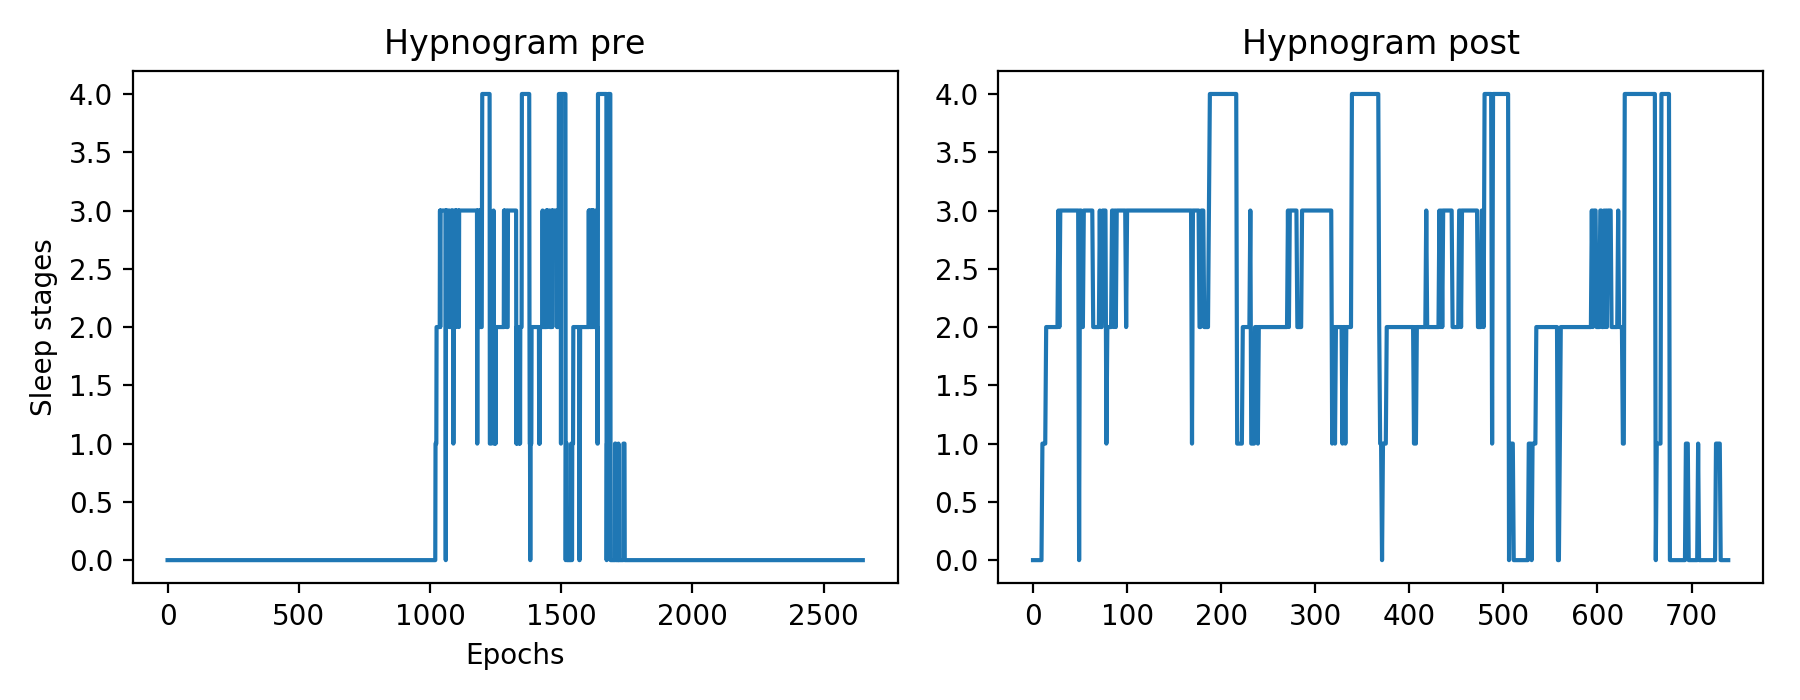

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(2*fig_w,fig_h))

plt.sca(axs[0])
hypno = dataset_record_ref['hypnogram']
plt.plot(dataset_record_ref['hypnogram'], label='pre')
plt.xlabel('Epochs')
plt.ylabel('Sleep stages')
plt.title('Hypnogram pre')

plt.sca(axs[1])
hypno = dataset[record_ref]['hypnogram']
plt.plot(hypno, label='pre')
plt.title('Hypnogram post')

plt.tight_layout()
fig.canvas.draw()

### Re-sample dataset to target frequency

The PSG records may contain channels sampled at different sampling rates and it may be necessary to set a global sampling rate and upsample or downsample channels accordingly. Downsampling PSG records has computational advantages by reducing the number of operations per mini-batch, and implements a natural low pass filter (at half the target frequency). Several studies indicate that low frequencies are the most relevant to sleep scoring.

In [21]:
from scipy import signal

def gcd(a, b):

    return gcd(b, a % b) if b else a


def updown(n1, n2):

    div = gcd(n1,n2)

    return (n2//div, n1//div)

In [22]:
# print unique frequencies in dataset

verbose = False

freqs = []
for record in dataset:
    freqs += dataset[record]['freqs']
    
print('(pre) unique frequencies in dataset', sorted(set(freqs)))

# resample dataset to target frequency
for record in dataset:
    
    for idx_channel, channel in enumerate(dataset[record]['channels']):
    
        freq = dataset[record]['freqs'][idx_channel]
        
        if freq!=freq_target:
            
            up, down = updown(freq, freq_target)
            
            data = dataset[record]['signals'][idx_channel]

            data_d = sp.signal.resample_poly(np.concatenate(data, axis=0), up, down)
            
            dataset[record]['signals'][idx_channel] = np.array(np.split(data_d , data.shape[0]))
            dataset[record]['freqs'][idx_channel] = freq_target
            
            if verbose:
                
                print(record, channel, freq, '->', freq_target)
        
# print unique frequencies in dataset

freqs = []
for record in dataset:
    freqs += dataset[record]['freqs']
    
print('(post) unique frequencies in dataset', sorted(set(freqs)))

(pre) unique frequencies in dataset [1.0, 100.0]


/share/anaconda2/lib/python2.7/site-packages/scipy/signal/signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]


(post) unique frequencies in dataset [60]


### Stack PSG channels into numpy array

This is now possible since all channels have the same sampling frequency.

In [25]:
for record in sorted(dataset):
    
    if type(dataset[record]['signals'])==type(list()):
        dataset[record]['signals']= np.stack(dataset[record]['signals'], axis=2)

    print('sample record\t', record)
    print('PSG channels shape:\t', dataset[record]['signals'].shape)
    print('hypnogram shape:\t', dataset[record]['hypnogram'].shape)

sample record	 SC4001E
PSG channels shape:	 (740, 1800, 4)
hypnogram shape:	 (740, 1)
sample record	 SC4011E
PSG channels shape:	 (1002, 1800, 4)
hypnogram shape:	 (1002, 1)
sample record	 SC4021E
PSG channels shape:	 (924, 1800, 4)
hypnogram shape:	 (924, 1)
sample record	 SC4031E
PSG channels shape:	 (851, 1800, 4)
hypnogram shape:	 (851, 1)
sample record	 SC4041E
PSG channels shape:	 (1135, 1800, 4)
hypnogram shape:	 (1135, 1)
sample record	 SC4051E
PSG channels shape:	 (571, 1800, 4)
hypnogram shape:	 (571, 1)
sample record	 SC4071E
PSG channels shape:	 (875, 1800, 4)
hypnogram shape:	 (875, 1)
sample record	 SC4081E
PSG channels shape:	 (1033, 1800, 4)
hypnogram shape:	 (1033, 1)
sample record	 SC4091E
PSG channels shape:	 (1042, 1800, 4)
hypnogram shape:	 (1042, 1)
sample record	 SC4101E
PSG channels shape:	 (1004, 1800, 4)
hypnogram shape:	 (1004, 1)
sample record	 SC4111E
PSG channels shape:	 (828, 1800, 4)
hypnogram shape:	 (828, 1)
sample record	 SC4121E
PSG channels shape:	 

## Plot PSG

<IPython.core.display.Javascript object>


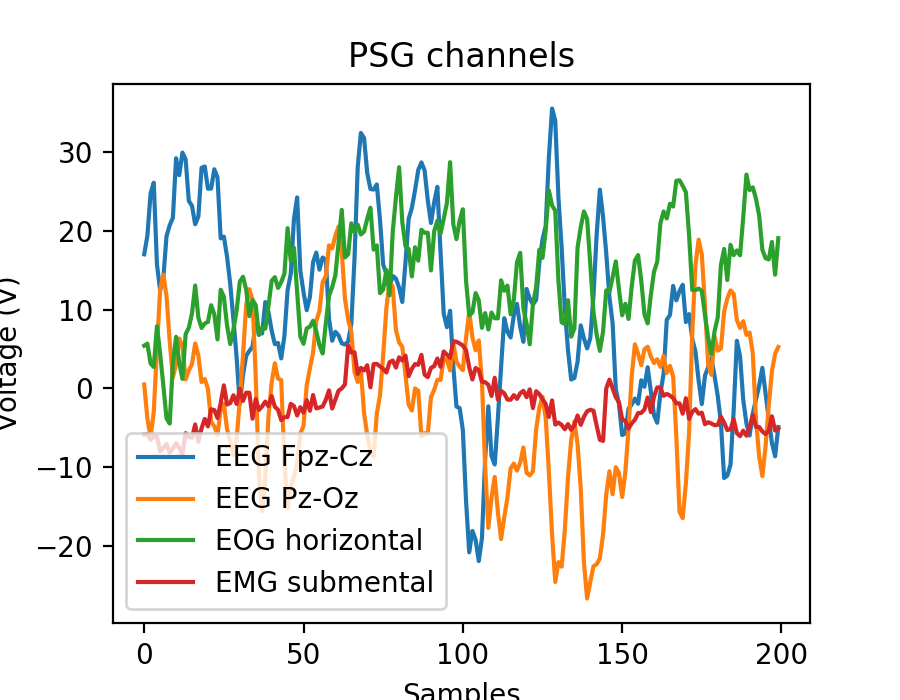

In [27]:
fig = plt.figure() #create a figure
for item_x, item_channel in zip(range(dataset[record]['signals'].shape[2]), channels_ref): #loop through x array
    
    data=dataset[record]['signals'][700,:200,item_x] #build data with the first 200 samples of epoch 1000 of array x
    plt.plot(data,label=str(item_channel)) #plot EEG channels
plt.title('PSG channels')  #add a title to the plot
plt.xlabel('Samples') #add a label to the x-axis
plt.ylabel('Voltage (V)')  #add a label to the y-axis
plt.legend()  #add a legend to the plot





## Plot histogram

<IPython.core.display.Javascript object>


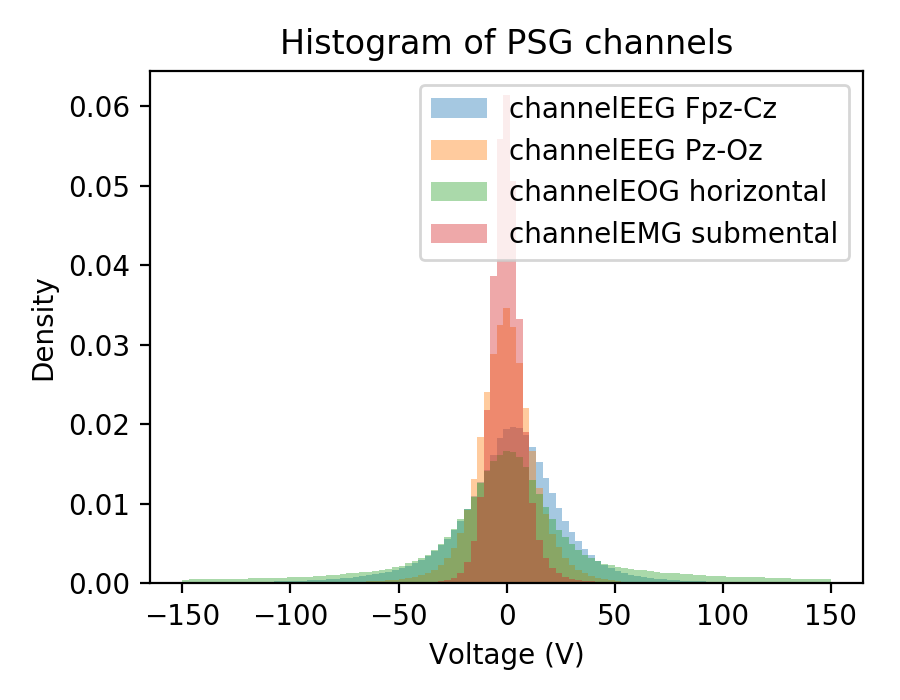

In [28]:
x_bins = np.linspace(-150,150,num=100)

fig = plt.figure()
for item_x, item_channel in zip(range(dataset[record]['signals'].shape[2]), channels_ref): #iterate over x array
    data = dataset[record]['signals'][:,:,item_x].flatten()
    plt.hist(data, bins=x_bins, density=True,
             alpha=0.4, label='channel'+str(item_channel)) #plot histogram of EEG channels

plt.title('Histogram of PSG channels')  #add a title to the histogram
plt.xlabel('Voltage (V)') #add a label to the x_axis
plt.ylabel('Density') #add a label to the y_axis
plt.legend() #add a legend to the plot
plt.tight_layout()



## Statistics Explore

In [29]:
def stats(x, channels_ref = channels_ref):
    """Print minimum, maximum, mean and standard deviation along dimension 2 of array.
    x: array with shape (epoch, sample, channel)""" 
    print('PSG'+'\t min\t\t max\t\t mean\t\t std\n')
    for item, item_channel in zip(range(x.shape[2]), dataset[record]['channels']): #iterate over x array
        print(item_channel,'\t','{0:.4f}'.format(np.min(x[:,:,item])),'\t','{0:.4f}'.format(np.max(x[:,:,item])),'\t','{0:.4f}'.format(np.mean(x[:,:,item])),'\t','{0:.4f}'.format(np.std(x[:,:,item])))#print statistics of array x (min,max,mean,std)


In [30]:
for record in dataset:
    print(record)
    
    print(stats(dataset[record]['signals']))

SC4101E
PSG	 min		 max		 mean		 std

EEG Fpz-Cz 	 -171.4030 	 137.6145 	 -0.9124 	 11.8430
EEG Pz-Oz 	 -161.2219 	 182.9925 	 0.0657 	 8.5942
EOG horizontal 	 -548.7430 	 506.4545 	 -0.6167 	 38.3691
EMG submental 	 -0.6042 	 4.8603 	 1.5380 	 1.2560
None
ST7121J
PSG	 min		 max		 mean		 std

EEG Fpz-Cz 	 -1750.3720 	 1171.1851 	 0.1616 	 45.2183
EEG Pz-Oz 	 -1386.5737 	 633.1160 	 0.1549 	 35.4530
EOG horizontal 	 -944.1345 	 863.2471 	 0.1155 	 92.5476
EMG submental 	 -309.6541 	 903.9360 	 0.1514 	 19.7716
None
SC4001E
PSG	 min		 max		 mean		 std

EEG Fpz-Cz 	 -192.6868 	 166.3584 	 0.1683 	 22.5209
EEG Pz-Oz 	 -167.1018 	 196.1816 	 -0.3528 	 15.0613
EOG horizontal 	 -506.3049 	 485.7747 	 0.8523 	 29.8731
EMG submental 	 -0.4328 	 4.0004 	 1.7278 	 1.0785
None
SC4131E
PSG	 min		 max		 mean		 std

EEG Fpz-Cz 	 -215.4991 	 200.4124 	 -0.0457 	 17.8736
EEG Pz-Oz 	 -181.4589 	 172.7834 	 0.3970 	 11.4783
EOG horizontal 	 -463.4922 	 449.3346 	 1.9147 	 29.5205
EMG submental 	 -0.3225 	

<IPython.core.display.Javascript object>


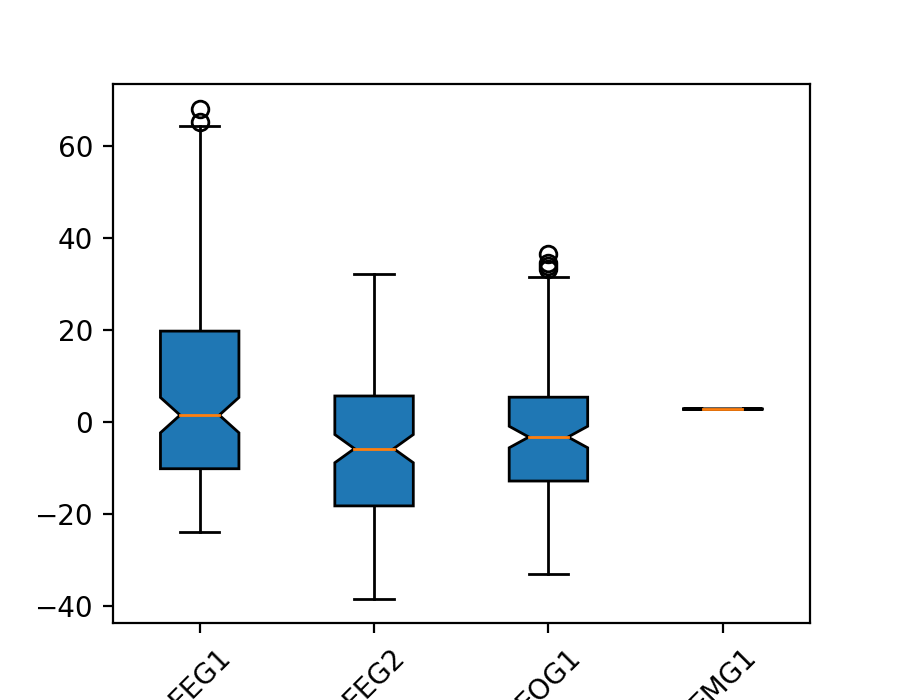

In [55]:

plt.figure()
data_to_plot = []

for item, item_channel in zip(range(dataset[record]['signals'].shape[2]), dataset[record]['channels']):
    data_to_plot += [dataset[record]['signals'][150,:150,item].flatten()]
    
plt.boxplot(data_to_plot, notch=True, patch_artist=True)
plt.xticks([1, 2, 3, 4], channels_ref_short, rotation=45)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.show()


### Normalize PSG data

Network models often work better after centering and scaling training data, either globaly or at mini-batch level.

In [56]:
# todo
def normalization(u):
    """Remove channel mean from array u and devide by standard deviation.
   u: array with shape (channel, batch, data)
   returns u_out: array u with zero channel mean and devided by standard deviation
    """
    u_out = u.copy()

    for idx in range(u_out.shape[2]):
        u_out[:,:,idx] = (u_out[:,:,idx] - np.mean(u_out[:,:,idx],keepdims=True))/(np.std(u_out[:,:,idx]))
    
    return u_out


In [57]:
for record in dataset:
    dataset[record]['signals'] = normalization(dataset[record]['signals'])
    

<IPython.core.display.Javascript object>


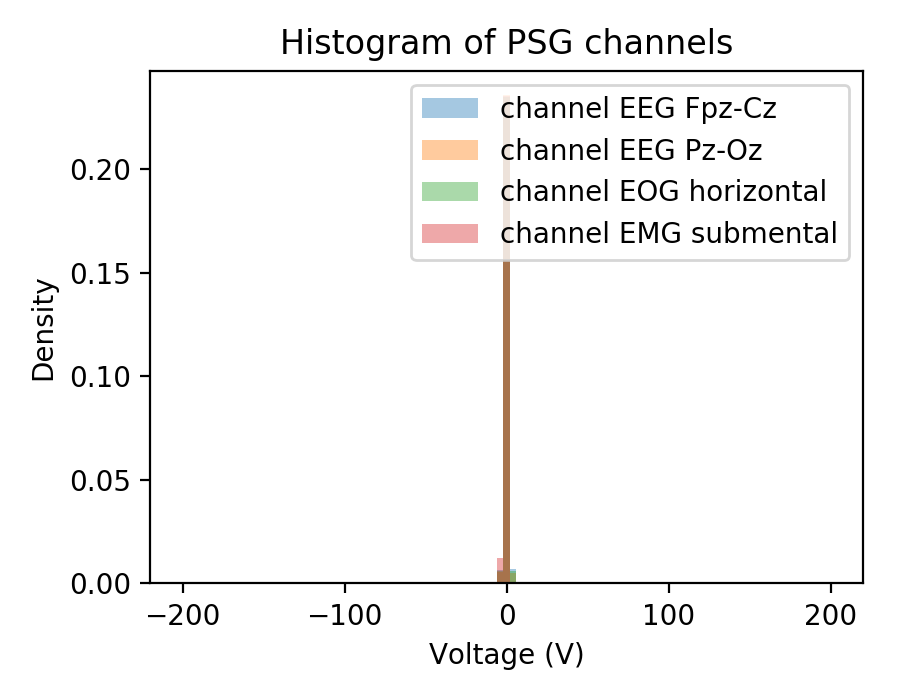

In [63]:
x_bins = np.linspace(-200, 200, num=100)

fig = plt.figure() #create a figure
for item_x, item_channel in zip(range(dataset[record]['signals'].shape[2]), channels_ref):  #loop through x array
    data = dataset[record]['signals'][:,:,item_x].flatten() 
    plt.hist(data, bins=x_bins, density=True, alpha=0.4, label='channel '+str(item_channel)) #plot histogram of array x
plt.title('Histogram of PSG channels') #add a title to the plot
plt.xlabel('Voltage (V)') #add a label to the x-axis
plt.ylabel('Density') #add a label to the y-axis
plt.legend() #add a legend to the plot

plt.tight_layout()

### Basic statistical metrics
Write function `print_stats()` to print minimum, maximum, mean and standard deviation of EEG channels in array `x`.

Print unique elements of array `y` and their proportions.

In [64]:
for record in dataset:
    print(stats(dataset[record]['signals']))

PSG	 min		 max		 mean		 std

EEG Fpz-Cz 	 -14.3959 	 11.6969 	 0.0000 	 1.0000
EEG Pz-Oz 	 -18.7671 	 21.2850 	 0.0000 	 1.0000
EOG horizontal 	 -14.2856 	 13.2156 	 0.0000 	 1.0000
EMG submental 	 -1.7056 	 2.6452 	 0.0000 	 1.0000
None
PSG	 min		 max		 mean		 std

EEG Fpz-Cz 	 -38.7129 	 25.8971 	 -0.0000 	 1.0000
EEG Pz-Oz 	 -39.1146 	 17.8535 	 0.0000 	 1.0000
EOG horizontal 	 -10.2029 	 9.3263 	 0.0000 	 1.0000
EMG submental 	 -15.6693 	 45.7114 	 -0.0000 	 1.0000
None
PSG	 min		 max		 mean		 std

EEG Fpz-Cz 	 -8.5634 	 7.3794 	 -0.0000 	 1.0000
EEG Pz-Oz 	 -11.0713 	 13.0490 	 0.0000 	 1.0000
EOG horizontal 	 -16.9770 	 16.2327 	 0.0000 	 1.0000
EMG submental 	 -2.0034 	 2.1071 	 -0.0000 	 1.0000
None
PSG	 min		 max		 mean		 std

EEG Fpz-Cz 	 -12.0543 	 11.2153 	 -0.0000 	 1.0000
EEG Pz-Oz 	 -15.8434 	 15.0184 	 0.0000 	 1.0000
EOG horizontal 	 -15.7655 	 15.1562 	 -0.0000 	 1.0000
EMG submental 	 -1.6001 	 3.6664 	 -0.0000 	 1.0000
None
PSG	 min		 max		 mean		 std

EEG Fpz-Cz 	 

In [65]:
y = dataset[record]['hypnogram']

In [66]:
print(y.shape)

(828, 1)


In [67]:
y_name = {0: 'AWA', 1:'N1', 2:'N2', 3:'N3', 4:'REM'} #build y_name dictionary
# insert your code here
y_keys = y_name.keys() #show keys of y_name dictionary
print('unique elements of hypnogram: {}'.format(y_keys))
for value in y_name.keys(): #loop through y_name dictionary
    p = len(y[y==value])/len(y) #set sleep stage proportion
    print(y_name[value],'\t{0:.4f}'.format(p)) #print sleep stage proportions

unique elements of hypnogram: [0, 1, 2, 3, 4]
AWA 	0.0314
N1 	0.0157
N2 	0.6063
N3 	0.1558
REM 	0.1908


In [69]:
x = dataset[record]['signals']

In [81]:
"""fig = plt.figure(figsize=(20,3.5))

for idx,item in enumerate(y_name.keys()): #loop through y_name dictionary 
    A=np.where(y==item)[0]
    plt.subplot(1,len(y_name.keys()),idx+1) #create a subplot for each 
    for index, channel in zip(range(x.shape[2]), channels_ref_short): #loop through x array
        data=x[A[2],:300,index] #create a data containing 200 samples of EEG 
        plt.plot(data+index/3,label='channel'+str(channel)) #plot EEG channels
    plt.title(y_name[item]) #add a title to each plot
    plt.xlabel('Samples') #add a label to x_axis of each subplot
    plt.legend()
    if idx==0:
        plt.ylabel('Voltage(V)') #add a label to y_axis
plt.tight_layout()"""

"fig = plt.figure(figsize=(20,3.5))\n\nfor idx,item in enumerate(y_name.keys()): #loop through y_name dictionary \n    A=np.where(y==item)[0]\n    plt.subplot(1,len(y_name.keys()),idx+1) #create a subplot for each \n    for index, channel in zip(range(x.shape[2]), channels_ref_short): #loop through x array\n        data=x[A[2],:300,index] #create a data containing 200 samples of EEG \n        plt.plot(data+index/3,label='channel'+str(channel)) #plot EEG channels\n    plt.title(y_name[item]) #add a title to each plot\n    plt.xlabel('Samples') #add a label to x_axis of each subplot\n    plt.legend()\n    if idx==0:\n        plt.ylabel('Voltage(V)') #add a label to y_axis\nplt.tight_layout()"